<a href="https://colab.research.google.com/github/sevenjunebaby/AiModels/blob/main/balancesmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The best_index_ is 2
The n_components selected is 10
The corresponding accuracy score is 0.88


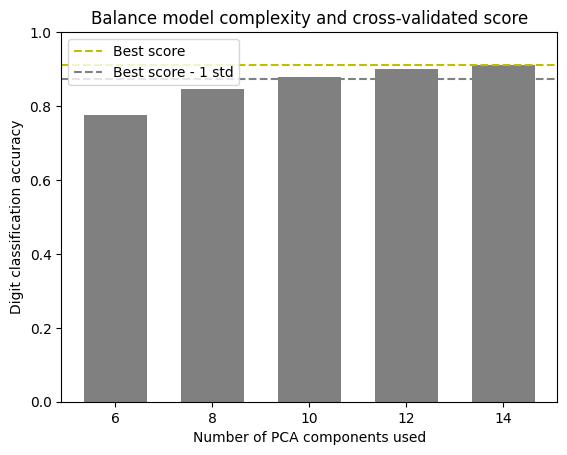

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Function to calculate the lower bound (best mean score - std deviation)
def lower_bound(cv_results):
    best_score_idx = np.argmax(cv_results["mean_test_score"])  # index of best mean score
    return (
        cv_results["mean_test_score"][best_score_idx]
        - cv_results["std_test_score"][best_score_idx]
    )

# Function to find the best model under a complexity constraint
# Selects the model with fewest components that still scores above the lower bound
def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)  # define threshold based on best score - std
    candidate_idx = np.flatnonzero(cv_results["mean_test_score"] >= threshold)
    best_idx = candidate_idx[
        cv_results["param_reduce_dim__n_components"][candidate_idx].argmin()
    ]
    return best_idx

# Create a pipeline:
# 1. Reduce dimensionality using PCA
# 2. Classify using Linear SVM
pipe = Pipeline(
    [
        ("reduce_dim", PCA(random_state=42)),
        ("classify", LinearSVC(random_state=42, C=0.01)),
    ]
)

# Grid search over different numbers of PCA components
param_grid = {"reduce_dim__n_components": [6, 8, 10, 12, 14]}

# Perform grid search with 10-fold cross-validation
# Custom refit strategy: prefer simpler model above a certain accuracy threshold
grid = GridSearchCV(
    pipe,
    cv=10,
    n_jobs=1,
    param_grid=param_grid,
    scoring="accuracy",
    refit=best_low_complexity,  # refit the simplest model with score above threshold
)

# Load digit dataset (handwritten digit images)
X, y = load_digits(return_X_y=True)

# Fit the model using grid search
grid.fit(X, y)

# Extract number of components and corresponding scores
n_components = grid.cv_results_["param_reduce_dim__n_components"]
test_scores = grid.cv_results_["mean_test_score"]

# Plotting the accuracy scores against number of PCA components
plt.figure()
plt.bar(n_components, test_scores, width=1.3, color="gray")

# Add horizontal lines showing best score and lower bound threshold
lower = lower_bound(grid.cv_results_)
plt.axhline(np.max(test_scores), linestyle="--", color="y", label="Best score")
plt.axhline(lower, linestyle="--", color=".5", label="Best score - 1 std")

# Plot formatting
plt.title("Balance model complexity and cross-validated score")
plt.xlabel("Number of PCA components used")
plt.ylabel("Digit classification accuracy")
plt.xticks(n_components.tolist())
plt.ylim((0, 1.0))
plt.legend(loc="upper left")

# Output the selected model details
best_index_ = grid.best_index_
print("The best_index_ is %d" % best_index_)
print("The n_components selected is %d" % n_components[best_index_])
print(
    "The corresponding accuracy score is %.2f"
    % grid.cv_results_["mean_test_score"][best_index_]
)

# Show the plot
plt.show()